# Chemometrics
<br>
**Julien Wist / 2017 / Universidad del Valle**
<br>
**Andrés Bernal / 2017 / ???**

An up-to-date version of this notebook can be found here: https://github.com/jwist/chemometrics/

Use the following commands to create the dataset of Table 2.6 of Brereton.

In [65]:
rm(list=ls(all=TRUE))

# we create the matrix manually
d <- c(6,60,4,34.841,6,60,2,16.567,6,20,4,45.396,6,20,2,27.939,4,60,4,19.825,4,60,2,1.444,4,20,4,37.673,4,20,2,23.131,6,40,3,23.088,4,40,3,12.325,5,60,3,16.461,5,20,3,33.489,5,40,4,26.189,5,40,2,8.337,5,40,3,19.192,5,40,3,16.579,5,40,3,17.794,5,40,3,16.65,5,40,3,16.799,5,40,3,16.635)
dim(d) <- c(4,20) # we force the data into a mtrix of dimension 4 x 20
# we create the data frame
datas <- data.frame("ph"=d[1,],"temp"=d[2,],"conc"=d[3,], "ph2"=d[1,]^2, "temp2"=d[2,]^2, "conc2"=d[3,]^2, "phTemp"=d[1,]*d[2,], "phConc"=d[1,]*d[3,], "tempConc"=d[2,]*d[3,], "yield"=d[4,])
datas

,ph,temp,conc,ph2,temp2,conc2,phTemp,phConc,tempConc,yield
1,6.000,60.000,4.000,36.000,3600.000,16.000,360.000,24.000,240.000,34.841
2,6.000,60.000,2.000,36.000,3600.000,4.000,360.000,12.000,120.000,16.567
3,6.000,20.000,4.000,36.000,400.000,16.000,120.000,24.000,80.000,45.396
4,6.000,20.000,2.000,36.000,400.000,4.000,120.000,12.000,40.000,27.939
5,4.000,60.000,4.000,16.000,3600.000,16.000,240.000,16.000,240.000,19.825
6,4.000,60.000,2.000,16.000,3600.000,4.000,240.000,8.000,120.000,1.444
7,4.000,20.000,4.000,16.000,400.000,16.000,80.000,16.000,80.000,37.673
8,4.000,20.000,2.000,16.000,400.000,4.000,80.000,8.000,40.000,23.131
9,6.000,40.000,3.000,36.000,1600.000,9.000,240.000,18.000,120.000,23.088
10,4.000,40.000,3.000,16.000,1600.000,9.000,160.000,12.000,120.000,12.325


In [66]:
# we define the matrix of data (X)
M <- as.matrix(datas[,1:9])
M <- cbind(rep(1,20),M) # adds intercept
# we define y, the response
y <- datas[,10]
# we calculate the regression coefficient manually
coeffs <- solve(t(M) %*% M) %*% t(M) %*% y
coeffs

,58.80808
ph,-6.090791
temp,-2.603282
conc,4.805145
ph2,0.5979091
temp2,0.01966602
conc2,0.1544091
phTemp,0.11005
phConc,0.351
tempConc,0.0291


In [67]:
# we can check that predictions are just projection of our data on the coefficients
predictions <- M %*% coeffs

# we start the evaluation of our model
Rep <- duplicated(datas[,1:3])
R <- sum( Rep ) 
N <- dim(datas)[1]
P <- length(coeffs)
D <- N - P - R

S_replicate <- sum( (mean(datas$yield[Rep]) - datas$yield[Rep])^2 ) # R degrees of freedom
S_residual <- sum ( (predictions - y)^2 ) # N-P degrees of freedom (# or S_total - S_predicted)
S_total <- sum( datas$yield^2 ) # N degrees of freedom
S_predicted <- sum( predictions^2 ) 
S_lackOfFit <- S_residual - S_replicate # N-P-R degrees of freedom
Rsquare <- S_predicted / S_total

meanS_replicate <- S_replicate / R
meanS_residual <- S_residual / (N-P)
meanS_total <- S_total / N
meanS_predicted <- S_predicted / P
meanS_lackOfFit <- S_lackOfFit / D

meanS_replicate;meanS_residual;meanS_total;meanS_predicted;meanS_lackOfFit

[1] 0.2089666

[1] 0.7987051

[1] 565.3971

[1] 1129.996

[1] 1.388444

In [68]:
F <- meanS_lackOfFit / meanS_replicate
F

[1] 6.644332

In [69]:
# we calculate t-values and their probability associated 
ttest <- coeffs / sqrt( diag( solve(t(M) %*% M) ) * meanS_residual )
1-(2 * pt(abs(ttest), df = N-P, lower.tail = FALSE))

,0.9989324
ph,0.7046699
temp,1
conc,0.7808861
ph2,0.7067975
temp2,1
conc2,0.2196673
phTemp,0.9999613
phConc,0.7073755
tempConc,0.9047041


## relation between the importance of variables and their magnitude
We can scale the data. Sometime this is referred to as encoding the data.

In [70]:
maxs <- apply(d[1:3,],1,max); mins <- apply(d[1:3,],1,min)
d[1:3,] <- t( scale(t(d)[,1:3],center = (mins + maxs)/2, scale = (maxs - mins)/2) )
datas <- data.frame("ph"=d[1,],"temp"=d[2,],"conc"=d[3,], "ph2"=d[1,]^2, "temp2"=d[2,]^2, "conc2"=d[3,]^2, "phTemp"=d[1,]*d[2,], "phConc"=d[1,]*d[3,], "tempConc"=d[2,]*d[3,], "yield"=d[4,])
datas

,ph,temp,conc,ph2,temp2,conc2,phTemp,phConc,tempConc,yield
1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,34.841
2,1.000,1.000,-1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,16.567
3,1.000,-1.000,1.000,1.000,1.000,1.000,-1.000,1.000,-1.000,45.396
4,1.000,-1.000,-1.000,1.000,1.000,1.000,-1.000,-1.000,1.000,27.939
5,-1.000,1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,1.000,19.825
6,-1.000,1.000,-1.000,1.000,1.000,1.000,-1.000,1.000,-1.000,1.444
7,-1.000,-1.000,1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,37.673
8,-1.000,-1.000,-1.000,1.000,1.000,1.000,1.000,1.000,1.000,23.131
9,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,23.088
10,-1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,12.325


In [71]:
# we define the matrix of data (X)
M <- as.matrix(datas[,1:9])
M <- cbind(rep(1,20),M) # adds intercept
# we define y, the response
y <- datas[,10]
# we calculate the regression coefficient manually
coeffs <- solve(t(M) %*% M) %*% t(M) %*% y
coeffs
# we can check that predictions are just projection of our data on the coefficients
predictions <- M %*% coeffs

# we start the evaluation of our model
Rep <- duplicated(datas[,1:3])
R <- sum( Rep ) 
N <- dim(datas)[1]
P <- length(coeffs)
D <- N - P - R

S_replicate <- sum( (mean(datas$yield[Rep]) - datas$yield[Rep])^2 ) # R degrees of freedom
S_residual <- sum ( (predictions - y)^2 ) # N-P degrees of freedom (# or S_total - S_predicted)
S_total <- sum( datas$yield^2 ) # N degrees of freedom
S_predicted <- sum( predictions^2 ) 
S_lackOfFit <- S_residual - S_replicate # N-P-R degrees of freedom
Rsquare <- S_predicted / S_total

meanS_replicate <- S_replicate / R
meanS_residual <- S_residual / (N-P)
meanS_total <- S_total / N
meanS_predicted <- S_predicted / P
meanS_lackOfFit <- S_lackOfFit / D

meanS_replicate;meanS_residual;meanS_total;meanS_predicted;meanS_lackOfFit

F <- meanS_lackOfFit / meanS_replicate
F

# we calculate t-values and their probability associated 
ttest <- coeffs / sqrt( diag( solve(t(M) %*% M) ) * meanS_residual )
1-(2 * pt(abs(ttest), df = N-P, lower.tail = FALSE))

,17.20834
ph,5.3433
temp,-7.849
conc,8.6506
ph2,0.5979091
temp2,7.866409
conc2,0.1544091
phTemp,2.201
phConc,0.351
tempConc,0.582


[1] 0.2089666

[1] 0.7987051

[1] 565.3971

[1] 1129.996

[1] 1.388444

[1] 6.644332

,1
ph,1
temp,1
conc,1
ph2,0.7067975
temp2,1
conc2,0.2196673
phTemp,0.9999613
phConc,0.7073755
tempConc,0.9047041


Scaling the data allows us to directly compare the coefficients, since the significance of the variable is a product of its magnitude by the coefficients. Now, all variable weight the same (their norm is equal to 1), so their coefficient directly reflects their importance. By comparing results obtained with and without scaling the variables we inmediatly notice important changes. By not scaling the data you might have wrongly concluded that only the first 3 parameters were relevant, while a proper scaling of the data shows that the $T^2$ and pH$ \times T$ might be relevant as well.

For more on experimental design, please consult <a href="https://books.google.com.co/books?hl=en&lr=&id=2VMhevgIAlwC&oi=fnd&pg=PR5&dq=Chemometrics:+Data+Analysis+for+the+Laboratory+and+Chemical+Plant.+Richard+G.+Brereton&ots=0yf20e0tsF&sig=sI-Lcp3yiUHSafz51w6SqMDulIE#v=onepage&q=Chemometrics%3A%20Data%20Analysis%20for%20the%20Laboratory%20and%20Chemical%20Plant.%20Richard%20G.%20Brereton&f=false">Brereton, R.G., 2003. Chemometrics: data analysis for the laboratory and chemical plant. John Wiley & Sons., Ch. 2</a>

## dependence and correlation and orthogonality

We should try to explain the difference in results we obtained by scaling the data in this simple example. The main question we want to answer with this example is precisely about the importance of the IVs (temperature, pH, concentration and the intereaction terms). The fact that such a difference, not only in magnitude but also in trends (the ranking of importance is not maintained) call for a more thorough explanation.

Consider the following function: $y=x^2$

[1] 0.02222649

Warning message:
In chisq.test(x, y): Chi-squared approximation may be incorrect


	Pearson's Chi-squared test

data:  x and y
X-squared = 39800, df = 39601, p-value = 0.2394


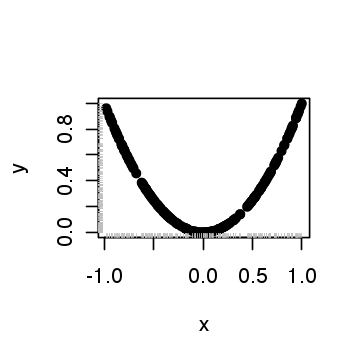

In [72]:
x <- runif(200,min=-1,max=1)
y <- x^2
plot(x,y,pch=16)
rug(x,side=1,col="grey")
rug(y,side=2,col="grey")
cor(x,y)
chisq.test(x,y)

and compare it with $y=x$

[1] 1

Warning message:
In chisq.test(x, y): Chi-squared approximation may be incorrect


	Pearson's Chi-squared test

data:  x and y
X-squared = 39800, df = 39601, p-value = 0.2394


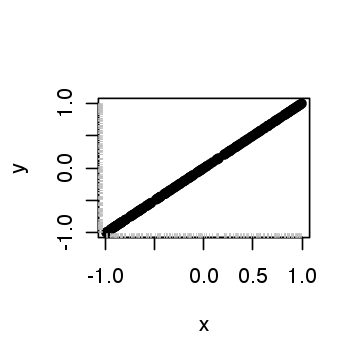

In [73]:
x <- runif(200,min=-1,max=1)
y <- x
plot(x,y,pch=16)
rug(x,side=1,col="grey")
rug(y,side=2,col="grey")
cor(x,y)
chisq.test(x,y) 

Despite in both cases $x$ and $y$ are dependent, in the left case they are completely uncorrelated. So being uncorrelated is not the same as being independent, but independant variables are uncorrelated. Two variables are considered independent when their joint probability distribution is equal to the product of their individual marginal probability distributions: $$P_{X,Y}(x,y)=P_X(x)P_Y(y)$$

Two variables are uncorrelated when their correlation coefficient is zero or when their covariance is equal to zero.

### correlations in experimental design

Experimental design is all about designing an experiment where the IV are uncorrelated so that effect of each IV can be studied separately. Then, by definition we can assume that IV are uncorrelated. You can check this for our chemical data. For example the correlation between pH and temperature is `r cor(datas$ph, datas$temp)`, while the correlation between ph and pH$\times$T is `r cor(datas$ph,datas$phTemp)`, non zero as expected.

if we look at the data for example for example for temperature and concentration we might have `r d[2,2:3]` and `r d[3,2:3]` for second and third point. If we represent them as vectors, we can see that both vectors are somehow collinear and that the product of both vectors is even more collinear.

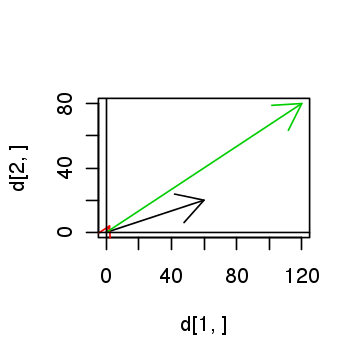

In [74]:
d <- c(6,60,4,34.841,6,60,2,16.567,6,20,4,45.396,6,20,2,27.939,4,60,4,19.825,4,60,2,1.444,4,20,4,37.673,4,20,2,23.131,6,40,3,23.088,4,40,3,12.325,5,60,3,16.461,5,20,3,33.489,5,40,4,26.189,5,40,2,8.337,5,40,3,19.192,5,40,3,16.579,5,40,3,17.794,5,40,3,16.65,5,40,3,16.799,5,40,3,16.635)
dim(d) <- c(4,20) # we force the data into a mtrix of dimension 4 x 20
# we create the data frame

plot(d[1,],d[2,], ylim=c(0,80), xlim=c(0,120),type='n')
for (i in 2) {
  arrows(x0=0, y0=0, x1=d[2,i], y1=d[2,i+1])
  arrows(x0=0, y0=0, x1=d[3,i], y1=d[3,i+1],col=2)
  arrows(x0=0, y0=0, x1=d[3,i]*d[2,i], y1=d[3,i+1]*d[2,i+1],col=3)
}
abline(0,0)
abline(v=0)

Now, if we scale / encode these data and draw again their vector we observe that they became orthogonal. So the collinearity has been reduced by proper scaling.


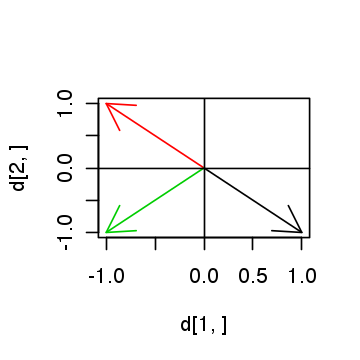

In [75]:
# scale with y <- (2*x - max(x) - min(x)) / (max(x)-min(x))
maxs <- apply(d[1:3,],1,max); mins <- apply(d[1:3,],1,min)
d[1:3,] <- t( scale(t(d)[,1:3],center = (mins + maxs)/2, scale = (maxs - mins)/2) )

plot(d[1,],d[2,], ylim=c(-1,1), xlim=c(-1,1),type='n')
for (i in 2) {
  arrows(x0=0, y0=0, x1=d[2,i], y1=d[2,i+1])
  arrows(x0=0, y0=0, x1=d[3,i], y1=d[3,i+1],col=2)
  arrows(x0=0, y0=0, x1=d[3,i]*d[2,i], y1=d[3,i+1]*d[2,i+1],col=3)
}
abline(0,0)
abline(v=0)

Collinearity should be avoided because it causes overfitting. The goal of a regression is to find the best variables (IVs) than explain most of the variance in the dependent variable (DV). This is usually measured by the explained variance, $R^2$, parameter. Too many collinear predictors may lead to high values of $R^2$ without the resulting model being necessarily useful. Collinear predictors are poor at describing the whole variable space. For example, we can find a best line that passes close to three points in space. If points are close, the error may be much larger, without incrementing the residuals, than if the three points are spread over a large distance. 

In addition, in the case of collinear variable, it will be difficult to rank them according to their importance to explain variance. Indeed the importance of a variable will depend on the order in which the variable are taken into account. If one vector explains a lot of variance, a collinear predictor that follow will not be able to explain anymore variance and will thus be discarded, although it contains important information.

<div class="ref">
http://creative-wisdom.com/computer/sas/collinear.html
</div>

<img src="./img/stepwise1.gif" width="200"><img src="./img/stepwise2.gif" width="200">

This is best illustrated by the above figures. In one case, each variable will explain its part of variance, while in the second case, several variable explain "the same" bit of variance.

### high number of variable

Imagine for a moment that the number of available variables (predictors) is much higher that the number of observation. In this case, the degree of freedom will become negative, that is the system lacks degrees of freedom, a situation which is referred to as overfitting. It is thus necessary to reduce the number of variables a task that is achieved by step-wise regression, etc. The general principles behind these methods consists in performing regressions with different combinations of variables in order to find out the ones to keep. 

However there are others and more robust alternatives to these methods that aknowledge the redundancy of information spanned by collinear predictors and try to convert collinearity of predictors (an issue) into reliability (a plusvalue). Such methods, as PLS (Projection to Latent Structure, a.k.a Partial Least Square), seek projecting predictors into composit variables to better explain the structure of the response. Moreover, PLS focuses on prediction, rather than fit, and is inherently weak at posterior interpretation of the relevant variables (this is also known as soft-modeling). Such methods also forms the domain of multivariate analysis, which should not be confused with multiple regression or multiple variable analysis. 